In [15]:
import netCDF4 as nc
import sys, os, argparse
import time
import numpy as np
from numpy import ma as ma

#Import packages for plotting
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import matplotlib.animation as animation
from matplotlib.ticker import MaxNLocator
from pylab import imshow,cm

#Import packages for clustering
from sklearn.cluster import KMeans
from scipy.linalg import eigh

#Import packages for geodesic distences
from pyproj import Geod


#Import packages for interpolating and filtering data
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from scipy.interpolate import LinearNDInterpolator as LNDI

# Import package for parallel computing
from joblib import Parallel, delayed

In [16]:
import sys, os
import numpy as np

# get current directory
path = os.getcwd()
# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-1])

# add utils and subfunctions folders to current working path
sys.path.append(parent_directory+"/subfunctions/latlon_transform")
sys.path.append(parent_directory+"/subfunctions/Similarity_matrix_construction")

# Import function for the polar rotation
from ipynb.fs.defs.polar_rotation import polar_rotation_rx 

In [17]:
parent_directory

'/home/llu/Programs/HPC_Spectral_Clustering'

In [18]:
'''
# Create the parser
parser = argparse.ArgumentParser(description="Process some parameters for clustering.")
# Add required arguments
parser.add_argument("Ncores", type=int, help="Number of CPU's")
parser.add_argument("file_path", type=str, help="Path to the file")
parser.add_argument("geo_file_path", type=str, help="Path to the file")
parser.add_argument("parent_directory", type=str, help="Parent directory")
parser.add_argument("results_directory", type=str, help="Results directory")
parser.add_argument("tmin", type=int, help="Minimum time")
parser.add_argument("tmax", type=int, help="Maximum time")
parser.add_argument("lat_resolution", type=float, help="Lat resolution for the IC grid in degrees")
parser.add_argument("lon_resolution", type=float, help="Lon resolution for the IC grid in degrees")
parser.add_argument("dt", type=float, help="Time step size for Runge Kutta")
parser.add_argument("DT", type=float, help="Time step size for Fmap")
parser.add_argument("geodesic", type=lambda x: x.lower() == 'true', help="Geodesic boolean for trajectory distance")
# Add optional argument with a default value
parser.add_argument("--freq", type=int, default=10, help="Frequency (default: 10)")
parser.add_argument("--K", type=int, default=1000, help="K similarity diagonal (default: 1000)")
parser.add_argument("--n_clusters", type=int, default=0, help="Number of clusters (default: 0 which gives the default number)")
parser.add_argument("--e", type=float, default=0, help="Sparsification parameter (default: 0 which translates to standard deviation)")
# Parse the arguments
args = parser.parse_args()


Ncores = args.Ncores
file_path = args.file_path
geo_file_path = args.geo_file_path
parent_directory = args.parent_directory
results_directory = args.results_directory
tmin = args.tmin
tmax = args.tmax
lat_resolution = args.lat_resolution
lon_resolution = args.lon_resolution
dt = args.dt
DT = args.DT
geodesic = args.geodesic
freq = args.freq
K = args.K
n_clusters = args.n_clusters
e = args.e
k_exp = 20

if not os.path.exists(results_directory):
    os.makedirs(results_directory)
'''

'\n# Create the parser\nparser = argparse.ArgumentParser(description="Process some parameters for clustering.")\n# Add required arguments\nparser.add_argument("Ncores", type=int, help="Number of CPU\'s")\nparser.add_argument("file_path", type=str, help="Path to the file")\nparser.add_argument("geo_file_path", type=str, help="Path to the file")\nparser.add_argument("parent_directory", type=str, help="Parent directory")\nparser.add_argument("results_directory", type=str, help="Results directory")\nparser.add_argument("tmin", type=int, help="Minimum time")\nparser.add_argument("tmax", type=int, help="Maximum time")\nparser.add_argument("lat_resolution", type=float, help="Lat resolution for the IC grid in degrees")\nparser.add_argument("lon_resolution", type=float, help="Lon resolution for the IC grid in degrees")\nparser.add_argument("dt", type=float, help="Time step size for Runge Kutta")\nparser.add_argument("DT", type=float, help="Time step size for Fmap")\nparser.add_argument("geodesi

In [19]:

K=1000
Ncores = 10
geo_file_path = "/home/llu/Data/OPA-neXtSIM_CREG025_ILBOXE140_2010_ice_latlon_rot_jacob.nc"
parent_directory = "/home/llu/Programs/HPC_Spectral_Clustering/"
tmin = 0
tmax = 360
lat_resolution = 0.25
lon_resolution = 0.25
dt = 1
DT = 10
freq = 1
timemod = int(DT/dt) #10
geodesic=False
n_clusters=0
e=0
k_exp = 20

Cluster_params = (
    f"geodesic_{geodesic}_"
    f"nclusters{n_clusters}_"
    f"e{e}"
)

W_params = (
    f"geodesic_{geodesic}"
)


# Initial file path
file_path = "/home/llu/Data/Fmap_tmin0_tmax360_latlonres0.25x0.25_dt1_DT10/"
# Construct results directory path
results_directory = f"{file_path}/{Cluster_params}/"
if not os.path.exists(results_directory):
    os.makedirs(results_directory)


In [20]:
# add utils folder to the TBarrier package
#sys.path.append(T_Barrier_directory+"/subfunctions/utils")
#sys.path.append(T_Barrier_directory+"/subfunctions/integration")
# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/Similarity_matrix_clustering")
sys.path.append(parent_directory+"/utils")


from ipynb.fs.defs.from_similarity_to_eigen import from_similarity_to_eigen

from ipynb.fs.defs.ploters import ini_final_clusters
from ipynb.fs.defs.ploters import gif_clusters
from ipynb.fs.defs.ploters import ini_final_clusters_landmask
from ipynb.fs.defs.ploters import gif_clusters_landmask


In [21]:
print("Reading data")
#Read input data

file_path="/home/llu/Programs/HPC_Spectral_Clustering/Data/Fmap_tmin0_tmax360_latlonres1x1_dt0.1_DT2/geodesic_False_nclusters0_e0/"

Fmap_path = file_path+'Fmap_geodesic_False_nclusters0_e0.0.npy'
labels_path = file_path+'/Clusters_labels_geodesic_False_nclusters0_e0.0.npy'

# Load the Fmap array from the file
Fmap = np.load(Fmap_path)  # ntime [lon,lat] ntrajectories
IC = Fmap[0,:,:]  #Take the position of the trajectory IC
# Load the labels of the clusters
labels= np.load(labels_path)

dataset = nc.Dataset(geo_file_path, mode='r')

#from m/s to m/day
siu = dataset.variables['vlon'][0,:,:]
land_mask=siu[:,:].mask

# Access coordinates
latitude = dataset.variables['rot_lat'][:]  
longitude = dataset.variables['rot_lon'][:]

dataset.close()


Reading data


In [22]:
IC.shape

(2, 990)

In [23]:
#Fmap dimensions

In [24]:
def gradient_matrix(IC,labels,i_batch,j_batch,geodesic=False,thereshold=1.5):
    w =  []
    for k in range(len(i_batch)):
        if (k%10000 == 0):
            print(k)
        s=gradient_labels(IC,labels,i_batch[k],j_batch[k],geodesic,thereshold)
        w = np.append(w,s)
    return w

In [25]:
def gradient_labels(IC, labels, i, j, geodesic , thereshold):
    if geodesic==False:
        # Compute pairwise distances at each time step
        distance = np.linalg.norm(IC[:, i] - IC[:, j], axis=1)
    else:
        # Define the WGS84 ellipsoid
        geod = Geod(ellps='WGS84')  #equivalent to +b=6356752 +a=6378137'

        #Go back to the non-rotated coordinates to compute the geodesic distances
        IC[1,:], IC[0,:] = polar_rotation_rx(np.array(IC[1,:]),np.array(IC[0,:]),-90)  #IC[0,:] contains longitudes and IC[1,:] latitudes
        distance =  geod.inv(IC[0, i], IC[1, i], IC[0, j], IC[1, j])[2] #distances in m

    if distance<=thereshold:
        return np.abs(labels[i]-labels[j])
    else:
        return 0



In [26]:
print("Preparing the parallel loop to compute the Similarity matrix") 
n = IC.shape[1]
print(f"{n} trajectories are being processed. Each trajectory has {Fmap.shape[0]} time steps.")

indices = np.tril_indices(n,0,n)

I=indices[0]
J=indices[1]

def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

I_batch = list(split(I, Ncores)) # list (Nx*Ny)
J_batch = list(split(J, Ncores)) # list (Nx*Ny)
print("Dimensions of W triangular")
print(n*n/2+n/2)

print("Length of the array with w values")
print(I_batch[0].shape)

Preparing the parallel loop to compute the Similarity matrix
990 trajectories are being processed. Each trajectory has 44 time steps.
Dimensions of W triangular
490545.0
Length of the array with w values
(49055,)


In [27]:
geodesic

False

In [28]:
print("Computing the similarity matrix with the parallel loop")
results = Parallel(n_jobs=Ncores, verbose = 10)(delayed(gradient_matrix)(IC, labels, I_batch[i], J_batch[i], geodesic, 2) for i in range(len(I_batch)))

gradients = results[0]

for res in results[1:]:
    gradients = np.append(gradients, res)

del(results)

Computing the similarity matrix with the parallel loop


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


0
0
0
0


AxisError: axis 1 is out of bounds for array of dimension 1

In [102]:
# Create an empty matrix of zeros with shape (n, n)
gradients_mx = np.zeros((n, n))
gradients_mx[indices] = gradients
# Fill the upper triangular part 
gradients_mx = gradients_mx + gradients_mx.T - np.diag(np.diag(gradients_mx))
#np.fill_diagonal(gradients_mx, 0)

Text(0.5, 1.0, 'Similarity matrix')

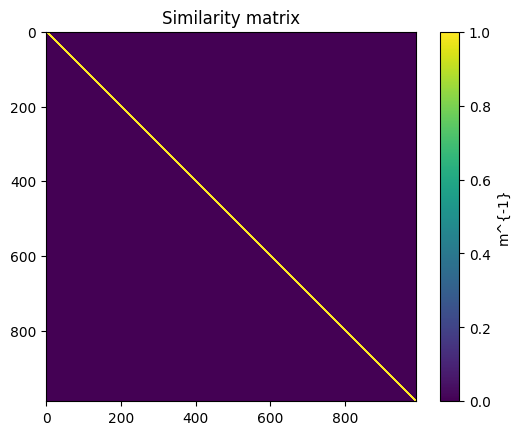

In [ ]:
imshow(gradients_mx,vmin=0,vmax=1)
cb=plt.colorbar()
if geodesic==True:
    cb.set_label("m^{-1}")
else:
    cb.set_label("deg^{-1}")
plt.title("Similarity matrix")
#plt.savefig(results_directory+'/W_matrix_'+W_params+'.png')


In [98]:
np.sum(gradients==0)

np.int64(489552)

In [99]:
gradients.shape

(490545,)